# Monitoring and representation of the evolution personnal heritage


## heritageDataDeltaInvestment.csv
Represents the net investments made on each support.
Worths have to be entered relatively to the previous one (that's why the file name contains "delta"). 

## heritageDataValue.csv
Represents the market worths of the different investment on a given date.
Worths have to be entered in an "absolute" way: the script will use each worth on the given time.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

import seaborn as sns

import json

from datetime import datetime

from math import log

pd.options.mode.chained_assignment = None

In [2]:
# Function definition
def display_as_percentage(val):
    if val > 0:
        return '+{:.1f}%'.format(val * 100)
    return '{:.1f}%'.format(val * 100)

def getyear(date):
    return date.year

In [3]:
# Import the investments structure from the json file

try:
    with open("investlabel.json", "r") as jsonfile:
        print("Investment labels are defined")
        investmentlabel = {}
        labelobject = json.load(jsonfile)
        for key,value in labelobject.items():
            investmentlabel[key] = value
except FileNotFoundError:
    print('Investment structure has to be defined')

# Count declared income and investment 
nbrIncome = ['Earning' in jsonCategoryKey for jsonCategoryKey,jsonCategoryValue in labelobject.items()].count(True)
nbrInvest = ['Investment' in jsonCategoryKey for jsonCategoryKey,jsonCategoryValue in labelobject.items()].count(True)

# Create a list of column name that should also exists in the csv files, see next step
colIncome = ['Earning' + str(i+1) for i in range(nbrIncome)]
colInvest = ['Investment' + str(i+1) for i in range(nbrInvest)]

Investment labels are defined


In [4]:
# load the investment file
investmentsdata = pd.read_csv('heritageDataDeltaInvestment.csv')

# get the income and investment column name from the csv
nbrIncomeCheck = len([col for col in investmentsdata.columns if 'Earning' in col])
colIncomeCheck = [col for col in investmentsdata.columns if 'Earning' in col]
nbrInvestCheck = len([col for col in investmentsdata.columns if 'Investment' in col])
colInvestCheck = [col for col in investmentsdata.columns if 'Investment' in col]

# Check if there is no definition error between the json structur and the csv files:
if (nbrIncomeCheck != nbrIncome or colIncomeCheck != colIncome or nbrInvestCheck != nbrInvest or colInvestCheck != colInvest):
    raise Exception('Check differences between the JSON structure and the CSV structures (names, number of earning source, nbr of investment...')
    
# Restructure the DF
investmentsdata = investmentsdata.melt(id_vars=["Date"], var_name="category")
investmentsdata['isInvestment'] = investmentsdata.category.apply(lambda x : True if 'Investment' in x else False)

#Convert format to date and sort them by date
investmentsdata.Date = pd.to_datetime(investmentsdata.Date)
investmentsdata.sort_values(by=['Date'], inplace = True)

In [5]:
#load the investment market worth
InvestMarketValues = pd.read_csv('heritageDataValue.csv')

# Restructure the DF
InvestMarketValues = InvestMarketValues.melt(id_vars=["Date"], var_name="category")

#Convert format to date and sort it by date
InvestMarketValues.Date = pd.to_datetime(InvestMarketValues.Date)
InvestMarketValues.sort_values(by=['Date'], inplace = True)

In [6]:
# Create a DF regrouping the earnings
earningtable = investmentsdata[investmentsdata.isInvestment == False]

# Creae a DF regroupring the investments
investtable = investmentsdata[investmentsdata.isInvestment == True]

## Data are now ready to get visualized

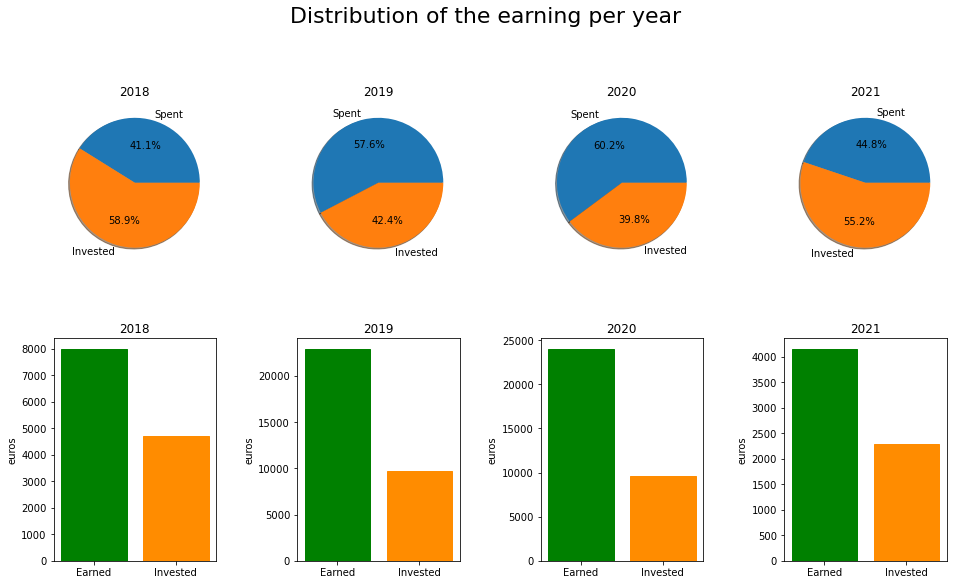

In [7]:
# Create a representation of the earning, spending, investment... per year. Can be interessant to prove
# our seriousness to a bank for exemple.
# All earning will be summed up and all investments will be summed up as well.

# Sort the data by years
earningPerYear = earningtable.copy()
earningPerYear.Date = earningPerYear.loc[:, 'Date'].apply(getyear)
earningPerYear = earningPerYear.groupby('Date').sum().reset_index()

investPerYear = investtable.copy()
investPerYear.Date = investPerYear.loc[:, 'Date'].apply(getyear)
investPerYear = investPerYear.groupby('Date').sum().reset_index()

# Defintion of the plots
fig, axes = plt.subplots(2,len(earningPerYear.index), figsize=(16,9))
fig.suptitle('Distribution of the earning per year', fontsize=22)

for currentYearIndex in range(len(earningPerYear.index)):
    # Re initialize the array
    pieData = []
    
    # Check if investment have been defined for the given earning year
    currentyear = earningPerYear.loc[currentYearIndex, 'Date']
    investPerYearIndex = investPerYear.index[investPerYear['Date'] == currentyear]

    if len(investPerYearIndex) == 0:
        print("Year " + str(currentyear) + " has no defined investment.")
        continue
    elif len(investPerYearIndex) > 1:
        print("Investments for year " + str(currentyear) + " has not been done correctly. Check the defined date format.")
        continue
        
    investPerYearIndex = investPerYearIndex[0]
    
    # get the earned and invested values
    i_earned = earningPerYear.loc[currentYearIndex,'value']
    i_invested = investPerYear.loc[investPerYearIndex,'value']
    
    #Check if we earned more than we invested
    #If its the case, we can display the pie chart
    #If its not the case, the pie chart will be an empty chart
    spentAmount = i_earned - i_invested
    ax = axes[0][currentYearIndex]
    if(spentAmount > 0):
        pieData.append(spentAmount) # calculate the spent amout 
        pieData.append(investPerYear.loc[investPerYearIndex,'value'])
        ax.pie(pieData,shadow=True, labels=['Spent','Invested'],autopct='%0.1f%%')
    ax.set(ylabel='', title=earningPerYear.loc[currentYearIndex, 'Date'], aspect='equal')
    
    # display on the second row a bar chart
    ax = axes[1][currentYearIndex]
    barData=[i_earned, i_invested]
    xbar = range(2)
    barplt = ax.bar(xbar, height=barData)
    barplt[0].set_color('green')
    barplt[1].set_color('darkorange')
    ax.set_xticks(xbar)
    ax.set_xticklabels(['Earned','Invested'])
    ax.set(ylabel='euros', title=earningPerYear.loc[currentYearIndex, 'Date'])

plt.subplots_adjust(wspace=0.5)
plt.show()

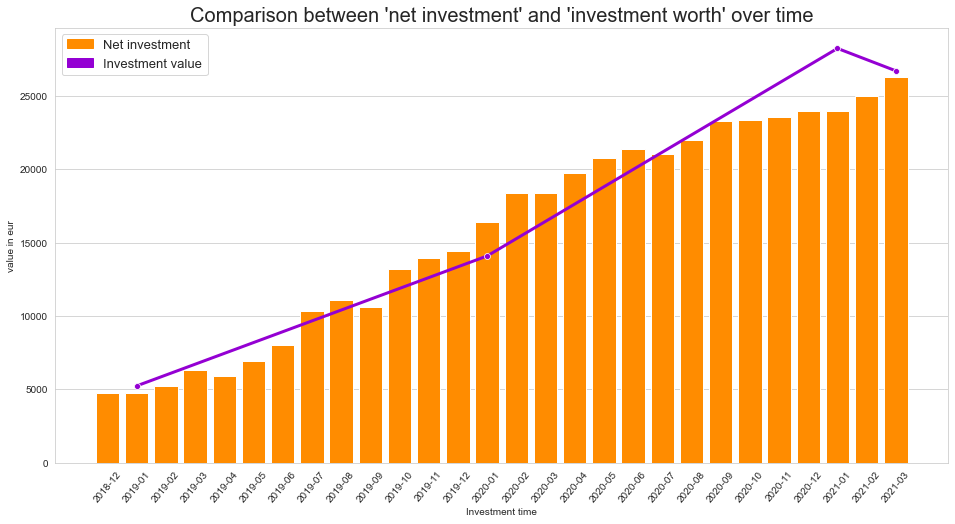

In [8]:
# Comparison between net investment vs investment worth

# Re organize the investment and market value by date
totalInvestPerPeriod = investtable.groupby('Date').sum().reset_index()
totalMarketValuePerPeriod = InvestMarketValues.groupby('Date').sum().reset_index()

# Sum up all investment, net value:
for i in range(1, len(totalInvestPerPeriod.Date)):
    totalInvestPerPeriod.at[i,'value'] = totalInvestPerPeriod.value[i] + totalInvestPerPeriod.value[i-1]

# Create a complet x axis using unique date from each dataframe
x_axis = list(set(list(totalInvestPerPeriod.Date) + list(totalMarketValuePerPeriod.Date)))

# Create NaN value for each table in which the date doesnt exists:
for date in x_axis:
    if not date in totalMarketValuePerPeriod.Date.values:
        new_row = {'Date': date}
        totalMarketValuePerPeriod = totalMarketValuePerPeriod.append(new_row, ignore_index=True)
    if not date in totalInvestPerPeriod.Date.values:
        new_row = {'Date': date}
        totalInvestPerPeriod = totalInvestPerPeriod.append(new_row, ignore_index=True)

# Re organize data per sorted by date
x_axis.sort()
totalMarketValuePerPeriod.sort_values(by=['Date'], inplace = True)
totalInvestPerPeriod.sort_values(by=['Date'], inplace = True)


sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(16,8))

# Display the net investment as barplot
ax = sns.barplot(data=totalInvestPerPeriod,x=x_axis,y='value',color="darkorange", alpha = 1, saturation=1)

# Display the investment worth as lineplot
sns.lineplot(data=totalMarketValuePerPeriod, x=ax.get_xticks(), y = 'value', marker="o", color='darkviolet', linewidth = 3)

# Format axis
x_labels = [date.strftime('%Y-%m') for date in x_axis]
ax.set_xticklabels(labels=x_labels,rotation=50)
plt.xlabel('Investment time')
plt.ylabel('value in eur')
plt.title('Comparison between \'net investment\' and \'investment worth\' over time', fontsize = 20)
handles, labels = ax.get_legend_handles_labels()
invest_patch = mpatches.Patch(color='darkorange', label='Net investment')
value_patch = mpatches.Patch(color='darkviolet', label='Investment value')
plt.legend(handles=[invest_patch,value_patch],fontsize=13)

plt.show()

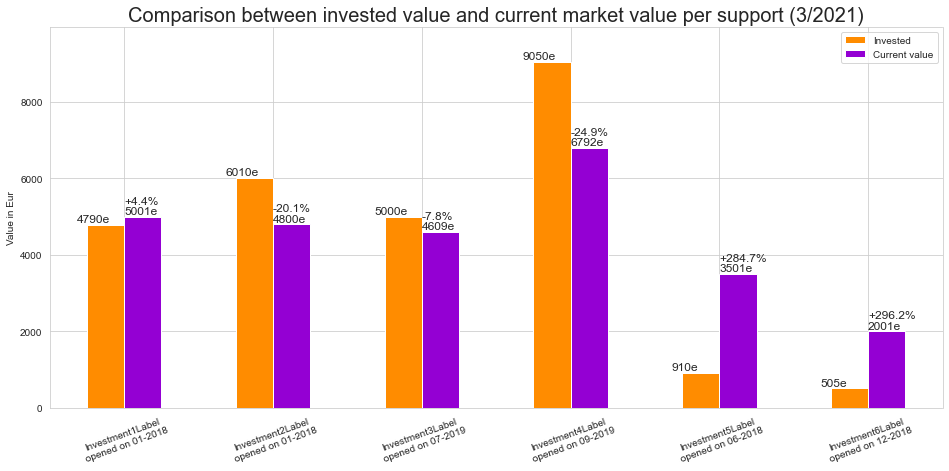

In [9]:
# Track performance of each support over time
# Comparision between invested vs worth for each support

# Re organize the investment and market value by date
totalInvestPerAsset = investtable.groupby('category').sum().reset_index()
lastInvestDate = investtable.Date.max()

totalMarketValuePerAsset = InvestMarketValues.tail(nbrInvest) # only keep last market value
totalMarketValuePerAsset = totalMarketValuePerAsset.sort_values(by=['category'])

maxValue = max(totalMarketValuePerAsset.value)

x = range(nbrInvest)
Invested = dict(zip(x,totalInvestPerAsset.value))
InvestedValue = dict(zip(x,totalMarketValuePerAsset.value))


# Display composed investment as barplot
dfbar = pd.DataFrame({'Invested': Invested, 'Current value': InvestedValue}, index=x)

sns.set_style("whitegrid")
ax = dfbar.plot.bar(figsize=(16, 7), color=['darkorange', 'darkviolet'])
xlabels = [investmentlabel[key]['Label'] + '\n opened on ' + investmentlabel[key]['OpeningDate'] for key in colInvest]
plt.xticks(ticks=x, labels = xlabels, rotation = 20)
plt.title('Comparison between invested value and current market value per support (' + str(lastInvestDate.month) + '/' + str(lastInvestDate.year) + ')' , fontsize=20)
plt.ylabel('Value in Eur')

for i, v in enumerate(dfbar.Invested):
    plt.text(i - 0.32, v + maxValue*0.01, "{:.0f}e".format(v), fontsize=12)

# Calculate the Rate of Return for each support
interests = [(InvestedValue[i] - Invested[i]) / Invested[i] for i in range(len(Invested))]

for i, v in enumerate(dfbar['Current value']):
    plt.text(i, v + maxValue*0.01, "{:.0f}e".format(InvestedValue[i]), fontsize=12)
    plt.text(i, v + maxValue*0.05, display_as_percentage(interests[i]), fontsize=12)

plt.margins(y=0.1)
plt.show()